## Visualization

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue);  library(glue); library(lubridate)
    library(scales); library(RColorBrewer); library(dplyr); library(tidyr); library(ggplot2)
    library(ggthemes); library(polloi)
})

In [2]:
file <- "metrics/metrics.tsv"
pageview <- read.csv(file, sep = '\t')
pageview$month <- as.Date(pageview$month, format = "%Y-%m-%d")

In [3]:
head(pageview)

,month,automated_pageviews,desktop,gs_interactions,gs_pageviews,gs_previews,interactions,mh_interactions,mh_pageviews,mh_previews,mobileweb,previews_seen,total_pageview,unique_devices
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-07-01,NA,7319709535,NA,NA,NA,NA,NA,NA,NA,6951477838,NA,14479097793,NA
2,2016-08-01,NA,7808198322,NA,NA,NA,NA,NA,NA,NA,7158465508,NA,15164063733,NA
3,2016-09-01,NA,8015803318,NA,3509314705,NA,NA,NA,482166702,NA,7037821889,NA,15227361307,NA
4,2016-10-01,NA,8597813074,NA,3649168724,NA,NA,NA,584002147,NA,7454268064,NA,16205992870,NA
5,2016-11-01,NA,8756368629,NA,3682761207,NA,NA,NA,639332261,NA,7568847051,NA,16499874726,NA
6,2016-12-01,NA,8140608026,NA,3397813382,NA,NA,NA,566587960,NA,7623805561,NA,15964600507,NA


In [4]:
tail(pageview)

,month,automated_pageviews,desktop,gs_interactions,gs_pageviews,gs_previews,interactions,mh_interactions,mh_pageviews,mh_previews,mobileweb,previews_seen,total_pageview,unique_devices
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
64,2021-10-01,901158808,6513036102,4356291999,3973495245,382796754,18360031885,NA,NA,NA,9701242496,1872863674,16487168211,1837564335
65,2021-11-01,881050513,6420327046,4247671454,3868069777,379601677,17768512101,NA,NA,NA,9209694162,1880481379,15888030722,1730051225
66,2021-12-01,955616294,5997304911,4053081990,3699153841,353928149,17629126726,NA,NA,NA,9545437010,1802475579,15826651147,1728498807
67,2022-01-01,1003626771,6657032289,4237581175,3860723508,376857667,19401297429,NA,NA,NA,10371244452,2058829668,17342467761,1775062017
68,2022-02-01,979406965,6381498663,4110316297,3767028146,343288151,17874089603,NA,NA,NA,9383265529,1833566161,16040523442,1827453153
69,2022-03-01,1000022585,6820776330,4407956608,4051236286,356720322,18950017723,NA,NA,NA,9870968780,1967056255,16982961468,1957129624


### Pageviews Interactions 

In [5]:
pageview_fy <- pageview %>% 
     select(month,total_pageview,previews_seen) %>%
     mutate(previews_seen = replace_na(previews_seen, 0)) %>%
     mutate(interactions = total_pageview+previews_seen) %>%
     filter(month >= '2019-07-01') %>%
     mutate(fiscal_year = ifelse(month >= '2019-07-01' & month < '2020-07-01', 'FY 2019/20', ifelse(month <'2019-07-01','FY 2018/19',ifelse(month <'2021-07-01','FY 2020/21','FY 2021/22'))),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

pageview_fy$MonthN = factor(pageview_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))

In [6]:
pageview_fy %<>%
    mutate(
        dataloss_affected = case_when(
                `month` >= "2021-06-01" & `month` < "2021-11-01" ~ TRUE,
                `month` >= "2021-11-01" & `month` < "2022-02-01" ~ TRUE,
                TRUE ~ FALSE
            )
    )

In [7]:
tail(pageview_fy)

,month,total_pageview,previews_seen,interactions,fiscal_year,MonthN,Month,dataloss_affected
,<date>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<lgl>
28,2021-10-01,16487168211,1872863674,18360031885,FY 2021/22,10,Oct,TRUE
29,2021-11-01,15888030722,1880481379,17768512101,FY 2021/22,11,Nov,TRUE
30,2021-12-01,15826651147,1802475579,17629126726,FY 2021/22,12,Dec,TRUE
31,2022-01-01,17342467761,2058829668,19401297429,FY 2021/22,01,Jan,TRUE
32,2022-02-01,16040523442,1833566161,17874089603,FY 2021/22,02,Feb,FALSE
33,2022-03-01,16982961468,1967056255,18950017723,FY 2021/22,03,Mar,FALSE


In [8]:
source("supplementary_files/pageview_dataloss_helper_functions.R")

In [9]:
pageviews_dataloss <- readr::read_tsv("supplementary_files/pageview_dataloss.tsv.gz", show_col_types = FALSE)

loss_bounds <- pageviews_dataloss %>%
    loss_boundaries() %>%
    bind_rows(.id = "which_loss")

loss_bounds

which_loss,lower,middle,upper
<chr>,<dbl>,<dbl>,<dbl>
loss1,0.02638790,0.03160639,0.03671803
loss2,0.05151559,0.06092645,0.06837827
none,0.00000000,0.00000000,0.00000000


In [10]:
dataloss_estimates_fy <- pageview_fy %>%
        mutate(
            which_loss = case_when(
                `month` >= "2021-06-01" & `month` < "2021-11-01" ~ "loss1",
                `month` >= "2021-11-01" & `month` < "2022-02-01" ~ "loss2",
                TRUE ~ "none"
            )
        ) %>%
        filter(which_loss != "none") %>%
        left_join(loss_bounds, by = "which_loss") %>%
        mutate(
            estimated_pageview_lower = total_pageview / (1 - lower),
            estimated_pageview_middle = total_pageview / (1 - middle),
            estimated_pageview_upper = total_pageview / (1 - upper),
            estimated_interactions_lower = previews_seen + estimated_pageview_lower,
            estimated_interactions_middle = previews_seen + estimated_pageview_middle,
            estimated_interactions_upper = previews_seen + estimated_pageview_upper
        )

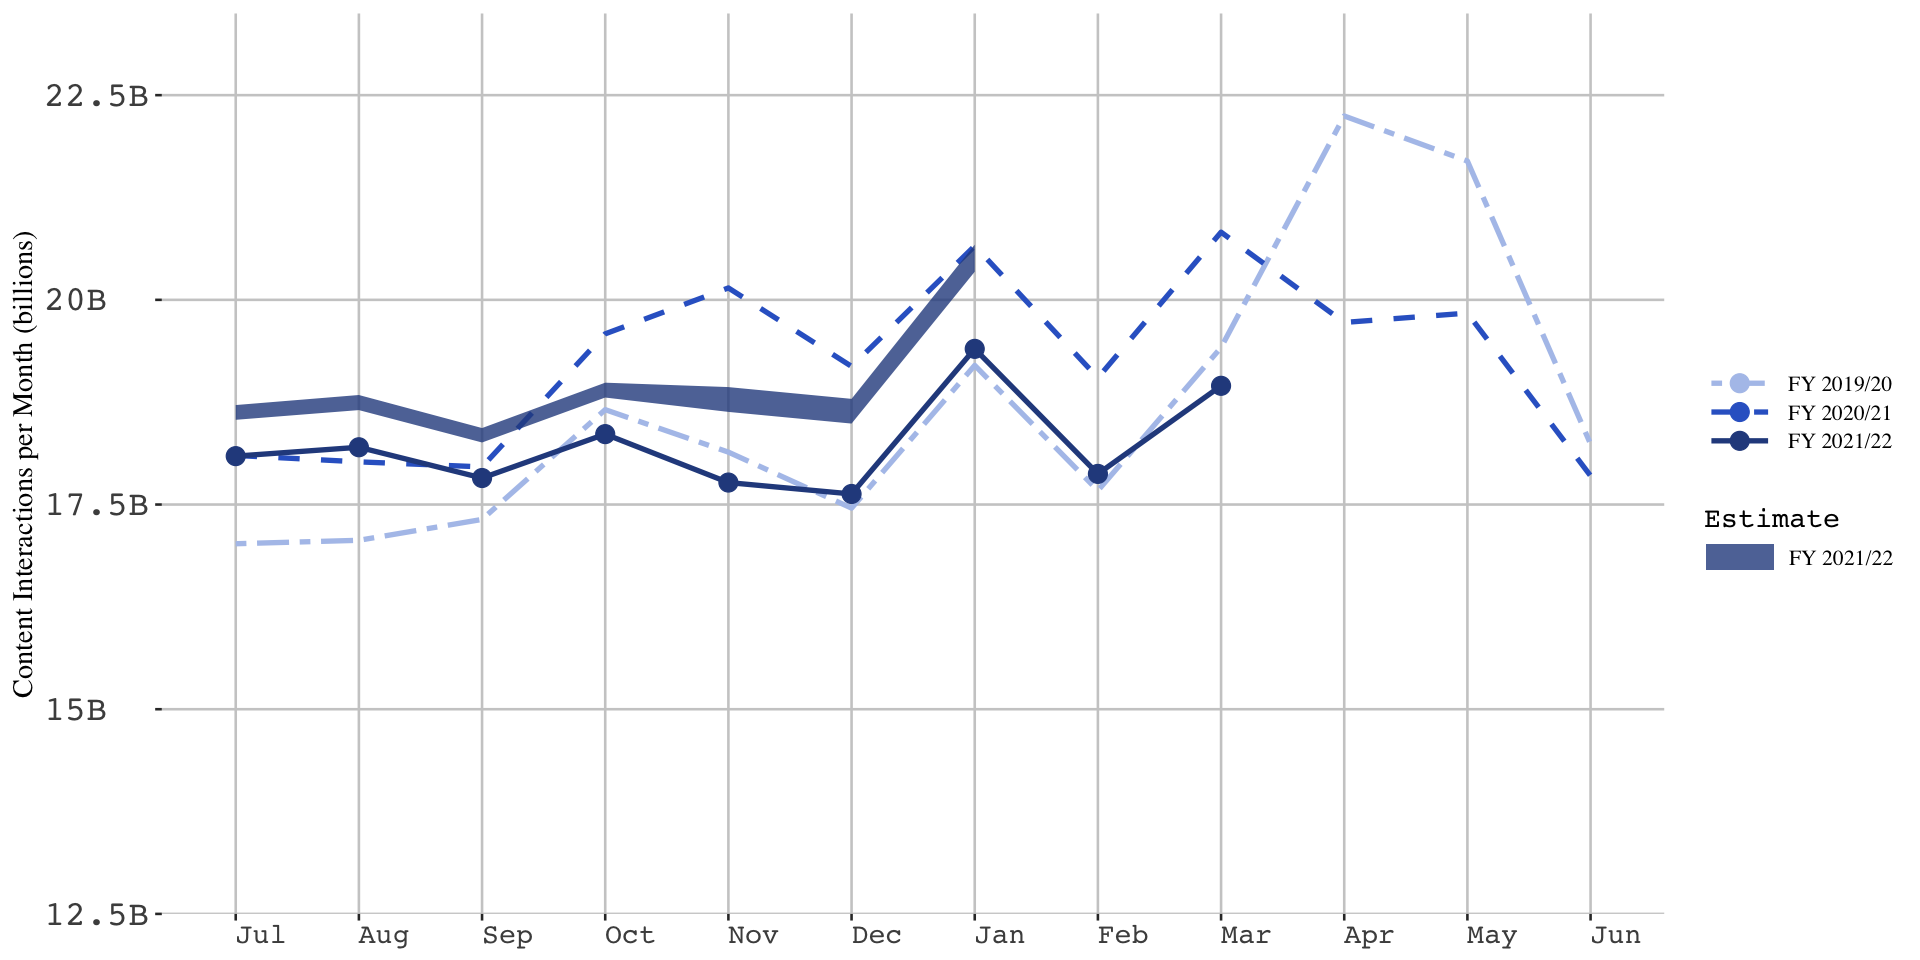

In [35]:
options(repr.plot.width = 16, repr.plot.height = 8)

ggplot(pageview_fy, aes(x = MonthN)) +
    geom_line(
        aes(
            y = interactions, group = fiscal_year, color = fiscal_year, linetype = fiscal_year,
            size = dataloss_affected
        ),
        size = 1.5
    ) +
    geom_point(
        data = pageview_fy %>%
            filter(fiscal_year == "FY 2021/22"),
        aes(y = interactions, group = fiscal_year, color = fiscal_year),
        size = 5
    ) +
    geom_ribbon(
        data = dataloss_estimates_fy %>%
            filter(fiscal_year == "FY 2021/22"),
        aes(
            ymin = estimated_interactions_lower, ymax = estimated_interactions_upper,
            group = fiscal_year, fill = fiscal_year
        ),
        alpha = 0.8
    ) +
    scale_linetype_manual(values = c("twodash", "dashed", "solid")) +
    scale_size_manual(values = c("TRUE" = 1, "FALSE" = 2)) +
    scale_fill_manual(values = c(
        "FY 2021/22" = "#2a4b8d"
    )) +
    scale_color_manual(values = c(
        "FY 2019/20" = "#b1c4eb",
        "FY 2020/21" = "#3366cc",
        "FY 2021/22" = "#2a4b8d"
    )) +
    scale_x_discrete(
        "Month",
        breaks = pageview_fy$MonthN, 
        labels = pageview_fy$Month
    ) +
    scale_y_continuous(
        "Content Interactions per Month (billions)",
        labels = polloi::compress,
        limits = c(13E9, 23E9)
    ) +
    guides(fill = guide_legend(
        title = "Estimate", title.theme = element_text(family = "Courier", size = 17))
    ) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(
        axis.title.x = element_blank(),
        axis.title = element_text(size = 17, hjust = 0.5, vjust = -12),
        axis.text.x = element_text(hjust = 0, size = 17, family = "Courier"),
        axis.text.y = element_text(hjust = 0, size = 21, family = "Courier"),
        panel.grid = element_line("gray80"),
        panel.grid.minor.y = element_blank(),
        plot.title = element_text(size = 20, hjust = 0.0, face = "bold"),
        legend.position = "right", 
        legend.title = element_blank(),
        legend.text = element_text(hjust = 0.5, size = 13),
        legend.key.width = unit(1.5, "cm")
    )

In [12]:
# Removed Interactions Bar - line chart as it is not used anymore